In [24]:
import time
t1 = time.time()
import os
import sys
import glob
from datetime import datetime
import numpy as np
from scipy import integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
from importlib import reload
import xarray as xr
# sys.path.append(r'D:\07. Software\jupyter')
# sys.path.append(r'D:\07. Software\jupyter\utils_gfat')
from utils_gfat import lidar, plot
from utils_gfat import lidarQA
from utils_gfat import lidar_elastic_retrieval
import lidar_processing.lidar_processing.helper_functions as helper_functions

In [25]:
dsd = {'alh':[], 'vlt':[]}
dsd['vlt'] = lidar.preprocessing(rs_fl='../VELETA/1a/2022/03/21/vlt_1a_Prs_rs_xf_20220321.nc',
                                dc_fl='../VELETA/1a/2022/03/21/vlt_1a_Pdc_rs_xf_20220321_1518.nc')

dsd['alh'] = lidar.preprocessing(rs_fl='../ALHAMBRA/1a/2022/03/21/alh_1a_Prs_rs_nf_20220321.nc',
                                 dc_fl='../ALHAMBRA/1a/2022/03/21/alh_1a_Pdc_rs_nf_20220321_1526.nc',)


INFO: lidar. preprocessing. L456: Start Lidar Preprocessing ...
INFO: lidar. preprocessing. L459: Read Raw Signal
INFO: lidar. reader_xarray. L264: Start Reader ...
INFO: lidar. reader_xarray. L276: ['../VELETA/1a/2022/03/21/vlt_1a_Prs_rs_xf_20220321.nc']
INFO: lidar. reader_xarray. L369: End Reader
INFO: lidar. preprocessing. L501: Read DC Signal
INFO: lidar. reader_xarray. L264: Start Reader ...
INFO: lidar. reader_xarray. L276: ['../VELETA/1a/2022/03/21/vlt_1a_Pdc_rs_xf_20220321_1518.nc']
INFO: lidar. reader_xarray. L369: End Reader
INFO: lidar. preprocessing. L533: Channel 355xpa
INFO. Start Get Bin Zero
Error. File ..\VELETA\1a\bin_zero.csv not found
INFO. End Get Bin Zero
Start DC Averaging
End DC Averaging
Start Analog Preprocessing
Start Estimate Background
End Estimate Background
End Analog Preprocessing
Start Analog Preprocessing
Start Estimate Background
End Estimate Background
End Analog Preprocessing
INFO: lidar. preprocessing. L533: Channel 355xpp
INFO. Start Get Bin Zero

INFO: lidar. merge_polarized_channels. L996: End Merge Polarized Channels
INFO: lidar. preprocessing. L712: End Lidar Preprocessing.


(19072.722222222223, 19072.73611111111)

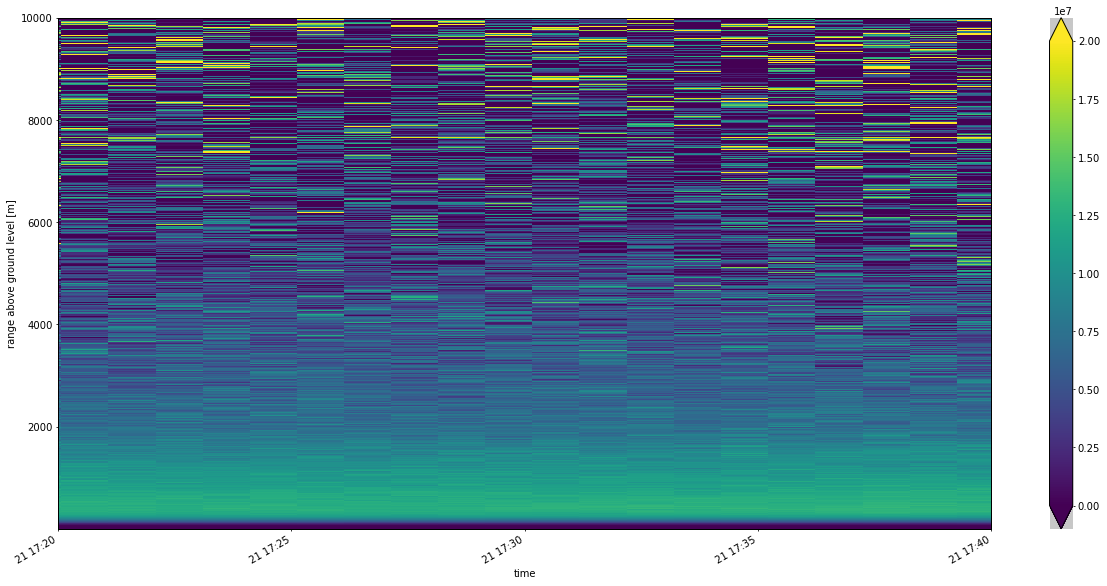

In [26]:
fig, ax = plt.subplots(figsize=[20,10])
(dsd['vlt'].signal_355xpp.sel(range=slice(0, 10000))*(dsd['vlt'].range**2)).T.plot(ax=ax,vmin = 0,vmax=2e7)
ax.set_xlim(datetime(2022,3,21,17,20),datetime(2022,3,21,17,40))


(19072.722222222223, 19072.73611111111)

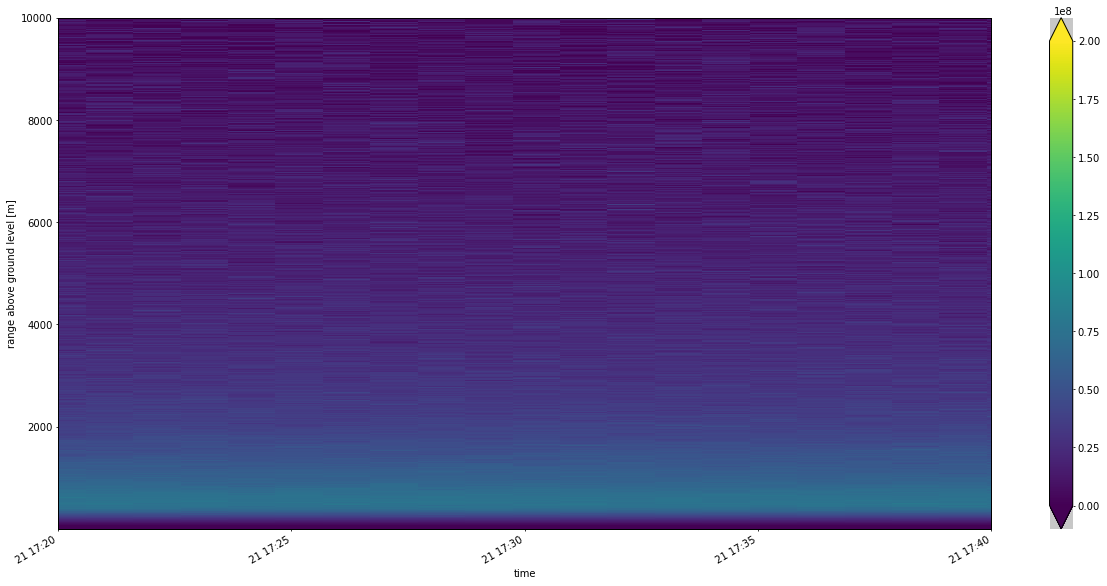

In [27]:
fig, ax = plt.subplots(figsize=[20,10])
(dsd['alh'].signal_355npp.sel(range=slice(0, 10000))*(dsd['vlt'].range**2)).T.plot(ax=ax,vmin = 0,vmax=2e8)
ax.set_xlim(datetime(2022,3,21,17,20),datetime(2022,3,21,17,40))


In [28]:
height = {'alh':[], 'vlt':[]}
height['alh'] = dsd['alh']['range'].values
height['vlt'] = dsd['vlt']['range'].values
molp = {'alh':[], 'vlt':[]}
for key in height.keys():
    temperature_prf = np.ones(height[key].size)*np.nan
    pressure_prf = np.ones(height[key].size)*np.nan
    for i, _height in enumerate(height[key]):
        sa = helper_functions.standard_atmosphere(_height)
        pressure_prf[i] = sa[0]
        temperature_prf[i] = sa[1]
    molp[key] = lidarQA.molecular_properties(355, pressure_prf,temperature_prf,height[key])

In [29]:
pressure_prf

array([101234.93006078, 101144.92496482, 101054.98467638, ...,
         5497.24129828,   5490.74827166,   5484.26291424])

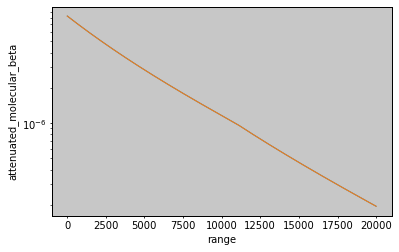

In [30]:
molp['vlt']['attenuated_molecular_beta'].plot()
molp['alh']['attenuated_molecular_beta'].plot()

plt.yscale('log')

In [31]:
ini_date = '20220321T172000.0'
end_date = '20220321T174000.0'
rcs_355xpa = dsd['vlt'].signal_355xpa.sel(time=slice(ini_date, end_date)).mean('time')*dsd['vlt'].range**2
rcs_355xpp = dsd['vlt'].signal_355xpp.sel(time=slice(ini_date, end_date)).mean('time')*dsd['vlt'].range**2
rcs_355npa = dsd['alh'].signal_355npa.sel(time=slice(ini_date, end_date)).mean('time')*dsd['alh'].range**2
rcs_355npp = dsd['alh'].signal_355npp.sel(time=slice(ini_date, end_date)).mean('time')*dsd['alh'].range**2

In [32]:
ymin, ymax = 4000, 4500
nrcs_355xpa = rcs_355xpa/rcs_355xpa.sel(range=slice(ymin, ymax)).mean('range')
nrcs_355xpp = rcs_355xpp/rcs_355xpp.sel(range=slice(ymin, ymax)).mean('range')
nrcs_355npa = rcs_355npa/rcs_355npa.sel(range=slice(ymin, ymax)).mean('range')
nrcs_355npp = rcs_355npp/rcs_355npp.sel(range=slice(ymin, ymax)).mean('range')
nattbeta = molp['alh']['attenuated_molecular_beta']/molp['alh']['attenuated_molecular_beta'].sel(range=slice(ymin, ymax)).mean('range')


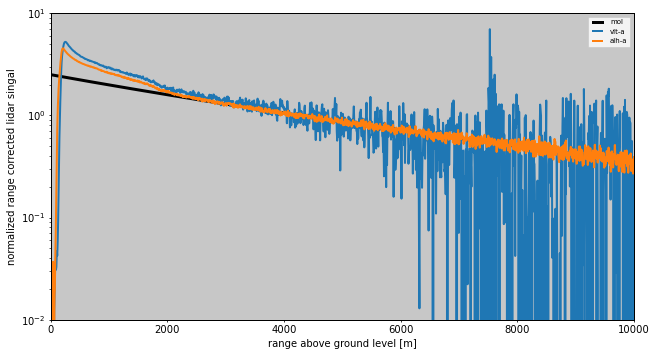

In [37]:
fig, ax = plt.subplots(figsize=[10,6])
nattbeta.plot(ax=ax, c='k',lw=3, label='mol')
# nattbeta532.plot(ax=ax, c='w',lw=3, label='mol532')
nrcs_355xpa.plot(ax=ax, lw=2, label='vlt-a')
nrcs_355npa.plot(ax=ax, lw=2, label='alh-a')
# nrcs_355xpp.plot(ax=ax, lw=2, label='vlt-p')
# # nrcs_355xta.plot(ax=ax, label='mhc-a')
# nrcs_355npp.plot(ax=ax, label='alh-p')

ax.legend()
ax.set_yscale('log')
ax.set_ylim(0.01,10)
ax.set_xlim(0,10000)
ax.set_ylabel('normalized range corrected lidar singal')
plt.savefig('result.png')

In [80]:
## dead rime correction

(0.0, 15000.0)

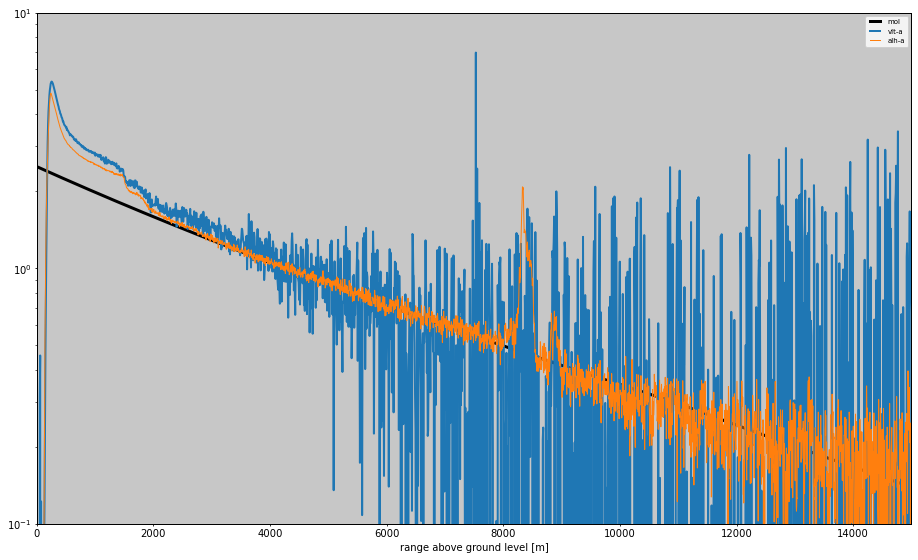

In [15]:
fig, ax = plt.subplots(figsize=[15,10])
nattbeta.plot(ax=ax, c='k',lw=3, label='mol')
# nattbeta532.plot(ax=ax, c='w',lw=3, label='mol532')
nrcs_355xpa.plot(ax=ax, lw=2, label='vlt-a')
# ax.plot(nrcs_355xpa.range.values,nrcs_355xpa.values,label='vlt-a')
ax.plot(nrcs_355npa.range.values[10:],nrcs_355npa.values[:-10],label='alh-a')
# ax.plot(nrcs_355npa.range.values,nrcs_355npa.values,label='alh-a2')


# nrcs_355npa.plot(ax=ax, label='mhc-a')

ax.legend()
ax.set_yscale('log')
ax.set_ylim(0.1,10)
ax.set_xlim(0,15000)

(0.0, 10000.0)

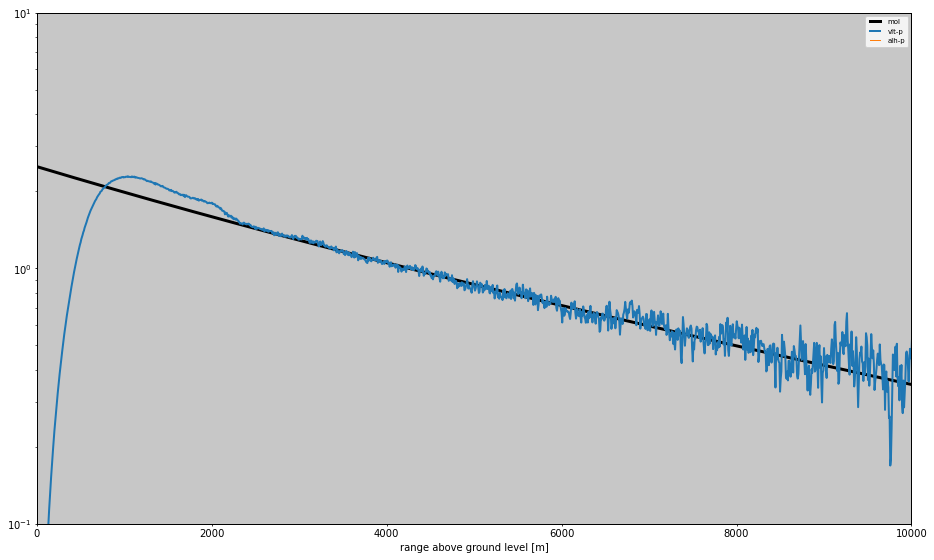

In [82]:
fig, ax = plt.subplots(figsize=[15,10])
nattbeta.plot(ax=ax, c='k',lw=3, label='mol')
# nattbeta532.plot(ax=ax, c='w',lw=3, label='mol532')
# nrcs_355xpa.plot(ax=ax, lw=2, label='vlt-a')
nrcs_355xpp.plot(ax=ax, lw=2, label='vlt-p')
# # nrcs_355xta.plot(ax=ax, label='mhc-a')
nrcs_355npp.plot(ax=ax, label='alh-p')

ax.legend()
ax.set_yscale('log')
ax.set_ylim(0.1,10)
ax.set_xlim(0,10000)

In [27]:
beta_part = {'alh':[], 'vlt':[]}
att_beta_total = {'alh':[], 'vlt':[]}
resolution = {'alh':[], 'vlt':[]}
# resolution['alh'] = height['alh'][1] - height['alh'][0]
# resolution['vlt'] = height['vlt'][1] - height['vlt'][0]
lr_aer = 40
lr_mol = molp['alh'].molecular_lidar_ratio.values

molbeta = {'alh':[], 'vlt':[]}

molbeta['alh'] = molp['alh']['molecular_beta'].values
molbeta['vlt'] = molp['vlt']['molecular_beta'].values


beta_part['vlt'] = lidar_elastic_retrieval.klett(rcs_355xpp.values, height['vlt'], molbeta['vlt'], lr_mol,
                              lr_aer = lr_aer, ymin = 4000, ymax = 5000)


beta_part['alh'] = lidar_elastic_retrieval.klett(rcs_355npp.values, height['alh'], molbeta['alh'], lr_mol,
                              lr_aer = lr_aer, ymin = 4000, ymax = 5000)


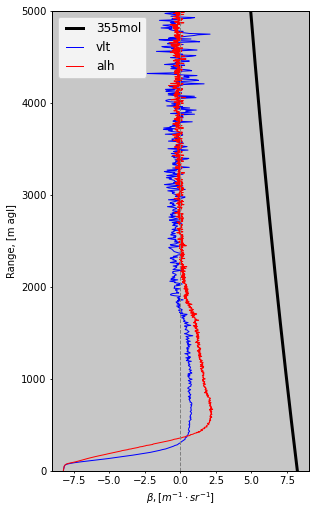

In [30]:
ymax_fig = 5000
fig, ax = plt.subplots(figsize=[15,9])
ax1 = plt.subplot(1,3,1)
ax1.plot(1e6*molbeta['vlt'], height['vlt'], c='k', lw=3, label='355mol')
ax1.plot(1e6*beta_part['vlt'], height['vlt'], c='b', label='vlt')
ax1.plot(1e6*beta_part['alh'], height['alh'], c='red', label='alh')
ax1.axvline(0,c='grey',ls='--')
# ax1.plot(beta_mol[532], height, c='lightgreen', lw=3, label='532mol')
# ax1.plot(beta_total[532], height, c='green', label='532total')
# ax1.plot(beta_mol[1064], height, c='pink', lw=3, label='1064mol')
# ax1.plot(beta_total[1064], height, c='red', label='1064total')
ax1.set_xlabel('$\\beta, [m^{-1}\cdot sr^{-1}]$')
ax1.set_ylabel('Range, [m agl]')
# ax1.set_xlim(-5e-7,1.25e-5)
# ax1.set_xscale('log')
# ax1.set_xlim(-2,5)
ax1.set_ylim([0,ymax_fig])
ax1.legend(fontsize='large')
plt.ticklabel_format(axis='x',style='sci',scilimits=(0,0))

In [32]:
beta_part = {'alh':[], 'vlt2':[],'vlt':[]}
att_beta_total = {'alh':[], 'vlt':[]}
resolution = {'alh':[], 'vlt':[]}
# resolution['alh'] = height['alh'][1] - height['alh'][0]
# resolution['vlt'] = height['vlt'][1] - height['vlt'][0]
lr_aer = 40
lr_mol = molp['alh'].molecular_lidar_ratio.values

molbeta = {'alh':[], 'vlt':[]}

molbeta['alh'] = molp['alh']['molecular_beta'].values
molbeta['vlt'] = molp['vlt']['molecular_beta'].values

bin_shift = 2

beta_part['vlt'] = lidar_elastic_retrieval.klett(rcs_355xpa.values, height['vlt'], molbeta['vlt'], lr_mol,
                              lr_aer = lr_aer, ymin = 2500, ymax = 3000)


beta_part['alh'] = lidar_elastic_retrieval.klett(rcs_355npa.values, height['alh'], molbeta['alh'], lr_mol,
                              lr_aer = lr_aer, ymin = 2500, ymax = 3000)


beta_part['vlt2'] = lidar_elastic_retrieval.klett(rcs_355xpa.values[bin_shift:], height['vlt'][:-1*bin_shift], 
                                                  molbeta['vlt'][:-1*bin_shift], lr_mol,
                              lr_aer = lr_aer, ymin = 2500, ymax = 3000)



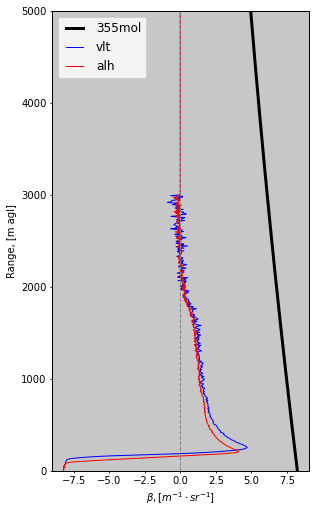

In [34]:
ymax_fig = 5000
fig, ax = plt.subplots(figsize=[15,9])
ax1 = plt.subplot(1,3,1)
ax1.plot(1e6*molbeta['vlt'], height['vlt'], c='k', lw=3, label='355mol')
ax1.plot(1e6*beta_part['vlt'], height['vlt'], c='b', label='vlt')
ax1.plot(1e6*beta_part['alh'], height['alh'], c='red', label='alh')
# ax1.plot(1e6*beta_part['vlt2'], height['vlt'][:-1*bin_shift], c='g', label='vlt2')

ax1.axvline(0,c='grey',ls='--')
# ax1.plot(beta_mol[532], height, c='lightgreen', lw=3, label='532mol')
# ax1.plot(beta_total[532], height, c='green', label='532total')
# ax1.plot(beta_mol[1064], height, c='pink', lw=3, label='1064mol')
# ax1.plot(beta_total[1064], height, c='red', label='1064total')
ax1.set_xlabel('$\\beta, [m^{-1}\cdot sr^{-1}]$')
ax1.set_ylabel('Range, [m agl]')
# ax1.set_xlim(-5e-7,1.25e-5)
# ax1.set_xscale('log')
# ax1.set_xlim(-2,5)
ax1.set_ylim([0,ymax_fig])
ax1.legend(fontsize='large')
plt.ticklabel_format(axis='x',style='sci',scilimits=(0,0))

In [41]:
ini_date = '20220321T172000.0'
end_date = '20220321T174000.0'
rcs_355xpa = dsd['vlt'].signal_355xsa.sel(time=slice(ini_date, end_date)).mean('time')*dsd['vlt'].range**2
rcs_355xpp = dsd['vlt'].signal_355xsp.sel(time=slice(ini_date, end_date)).mean('time')*dsd['vlt'].range**2
rcs_355npa = dsd['alh'].signal_355nsa.sel(time=slice(ini_date, end_date)).mean('time')*dsd['alh'].range**2
rcs_355npp = dsd['alh'].signal_355nsp.sel(time=slice(ini_date, end_date)).mean('time')*dsd['alh'].range**2

In [42]:
ymin, ymax = 4000, 5000
nrcs_355xpa = rcs_355xpa/rcs_355xpa.sel(range=slice(ymin, ymax)).mean('range')
nrcs_355xpp = rcs_355xpp/rcs_355xpp.sel(range=slice(ymin, ymax)).mean('range')
nrcs_355npa = rcs_355npa/rcs_355npa.sel(range=slice(ymin, ymax)).mean('range')
nrcs_355npp = rcs_355npp/rcs_355npp.sel(range=slice(ymin, ymax)).mean('range')
nattbeta = molp['alh']['attenuated_molecular_beta']/molp['alh']['attenuated_molecular_beta'].sel(range=slice(ymin, ymax)).mean('range')

(0.0, 10000.0)

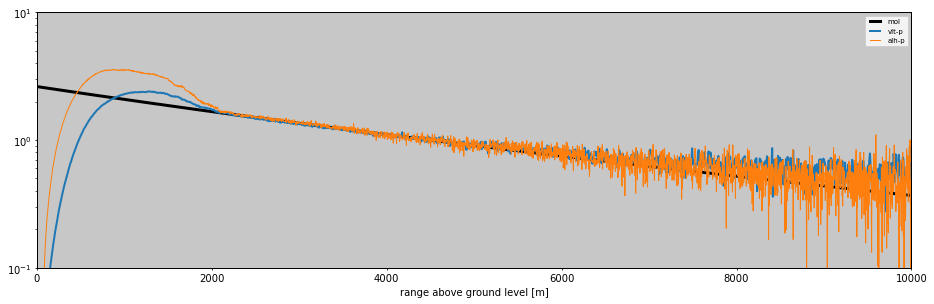

In [43]:
fig, ax = plt.subplots(figsize=[15,5])
nattbeta.plot(ax=ax, c='k',lw=3, label='mol')
# nattbeta532.plot(ax=ax, c='w',lw=3, label='mol532')
# nrcs_355xpa.plot(ax=ax, lw=2, label='vlt-a')
nrcs_355xpp.plot(ax=ax, lw=2, label='vlt-p')
# # nrcs_355xta.plot(ax=ax, label='mhc-a')
nrcs_355npp.plot(ax=ax, label='alh-p')

ax.legend()
ax.set_yscale('log')
ax.set_ylim(0.1,10)
ax.set_xlim(0,10000)

(0.0, 10000.0)

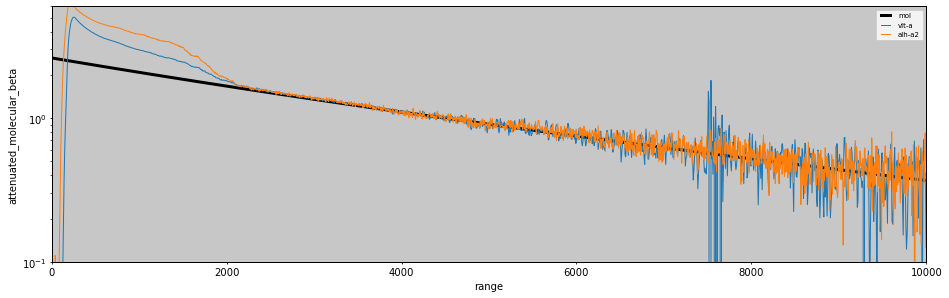

In [44]:
fig, ax = plt.subplots(figsize=[15,5])
nattbeta.plot(ax=ax, c='k',lw=3, label='mol')
# nattbeta532.plot(ax=ax, c='w',lw=3, label='mol532')
# nrcs_355xpa.plot(ax=ax, lw=2, label='vlt-a')
ax.plot(nrcs_355xpa.range.values,nrcs_355xpa.values,label='vlt-a')
# ax.plot(nrcs_355npa.range.values[10:],nrcs_355npa.values[:-10],label='alh-a')
ax.plot(nrcs_355npa.range.values,nrcs_355npa.values,label='alh-a2')


# nrcs_355npa.plot(ax=ax, label='mhc-a')

ax.legend()
ax.set_yscale('log')
ax.set_ylim(0.1,6)
ax.set_xlim(0,10000)

In [32]:
beta_part = {'alh':[], 'vlt':[]}
att_beta_total = {'alh':[], 'vlt':[]}
resolution = {'alh':[], 'vlt':[]}
# resolution['alh'] = height['alh'][1] - height['alh'][0]
# resolution['vlt'] = height['vlt'][1] - height['vlt'][0]
lr_aer = 40
lr_mol = molp['alh'].molecular_lidar_ratio.values

molbeta = {'alh':[], 'vlt':[]}

molbeta['alh'] = molp['alh']['molecular_beta'].values
molbeta['vlt'] = molp['vlt']['molecular_beta'].values


beta_part['vlt'] = lidar_elastic_retrieval.klett(rcs_355xpp.values, height['vlt'], molbeta['vlt'], lr_mol,
                              lr_aer = lr_aer, ymin = 4000, ymax = 5000)


beta_part['alh'] = lidar_elastic_retrieval.klett(rcs_355npp.values, height['alh'], molbeta['alh'], lr_mol,
                              lr_aer = lr_aer, ymin = 4000, ymax = 5000)

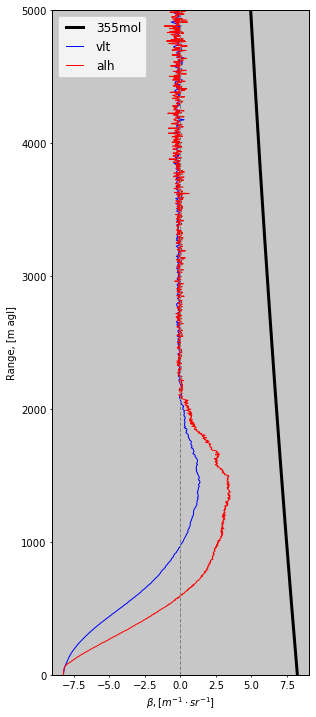

In [33]:
ymax_fig = 5000
fig, ax = plt.subplots(figsize=[15,13])
ax1 = plt.subplot(1,3,1)
ax1.plot(1e6*molbeta['vlt'], height['vlt'], c='k', lw=3, label='355mol')
ax1.plot(1e6*beta_part['vlt'], height['vlt'], c='b', label='vlt')
ax1.plot(1e6*beta_part['alh'], height['alh'], c='red', label='alh')
ax1.axvline(0,c='grey',ls='--')
# ax1.plot(beta_mol[532], height, c='lightgreen', lw=3, label='532mol')
# ax1.plot(beta_total[532], height, c='green', label='532total')
# ax1.plot(beta_mol[1064], height, c='pink', lw=3, label='1064mol')
# ax1.plot(beta_total[1064], height, c='red', label='1064total')
ax1.set_xlabel('$\\beta, [m^{-1}\cdot sr^{-1}]$')
ax1.set_ylabel('Range, [m agl]')
# ax1.set_xlim(-5e-7,1.25e-5)
# ax1.set_xscale('log')
# ax1.set_xlim(-2,5)
ax1.set_ylim([0,ymax_fig])
ax1.legend(fontsize='large')
plt.ticklabel_format(axis='x',style='sci',scilimits=(0,0))

In [34]:
beta_part = {'alh':[], 'vlt2':[],'vlt':[]}
att_beta_total = {'alh':[], 'vlt':[]}
resolution = {'alh':[], 'vlt':[]}
# resolution['alh'] = height['alh'][1] - height['alh'][0]
# resolution['vlt'] = height['vlt'][1] - height['vlt'][0]
lr_aer = 40
lr_mol = molp['alh'].molecular_lidar_ratio.values

molbeta = {'alh':[], 'vlt':[]}

molbeta['alh'] = molp['alh']['molecular_beta'].values
molbeta['vlt'] = molp['vlt']['molecular_beta'].values

bin_shift = 2

beta_part['vlt'] = lidar_elastic_retrieval.klett(rcs_355xpa.values, height['vlt'], molbeta['vlt'], lr_mol,
                              lr_aer = lr_aer, ymin = 2500, ymax = 3000)


beta_part['alh'] = lidar_elastic_retrieval.klett(rcs_355npa.values, height['alh'], molbeta['alh'], lr_mol,
                              lr_aer = lr_aer, ymin = 2500, ymax = 3000)


beta_part['vlt2'] = lidar_elastic_retrieval.klett(rcs_355xpa.values[bin_shift:], height['vlt'][:-1*bin_shift], 
                                                  molbeta['vlt'][:-1*bin_shift], lr_mol,
                              lr_aer = lr_aer, ymin = 2500, ymax = 3000)


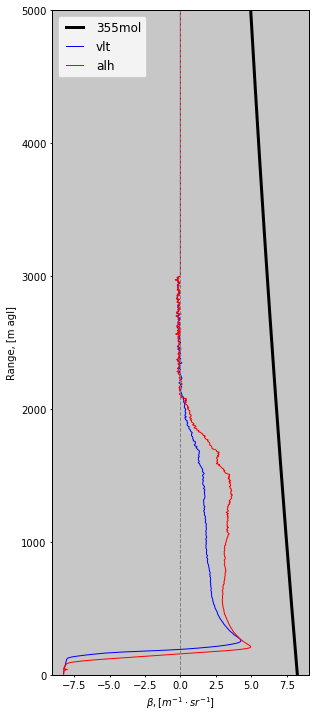

In [35]:
ymax_fig = 5000
fig, ax = plt.subplots(figsize=[15,13])
ax1 = plt.subplot(1,3,1)
ax1.plot(1e6*molbeta['vlt'], height['vlt'], c='k', lw=3, label='355mol')
ax1.plot(1e6*beta_part['vlt'], height['vlt'], c='b', label='vlt')
ax1.plot(1e6*beta_part['alh'], height['alh'], c='red', label='alh')
# ax1.plot(1e6*beta_part['vlt2'], height['vlt'][:-1*bin_shift], c='g', label='vlt2')

ax1.axvline(0,c='grey',ls='--')
# ax1.plot(beta_mol[532], height, c='lightgreen', lw=3, label='532mol')
# ax1.plot(beta_total[532], height, c='green', label='532total')
# ax1.plot(beta_mol[1064], height, c='pink', lw=3, label='1064mol')
# ax1.plot(beta_total[1064], height, c='red', label='1064total')
ax1.set_xlabel('$\\beta, [m^{-1}\cdot sr^{-1}]$')
ax1.set_ylabel('Range, [m agl]')
# ax1.set_xlim(-5e-7,1.25e-5)
# ax1.set_xscale('log')
# ax1.set_xlim(-2,5)
ax1.set_ylim([0,ymax_fig])
ax1.legend(fontsize='large')
plt.ticklabel_format(axis='x',style='sci',scilimits=(0,0))